In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import numpy as np
import openpyxl
from scipy.stats import gaussian_kde

(가정) 유기첨가제 brightner(광택제)는 실제 장비의 구동 시간과 선형 관계에 있을것이다.
- 데이터는 간헐적 데이터가 아닌 연속된 데이터로 가정
- 데이터는 1일 1회 첨가제를 주입

In [4]:
# raw 데이터 읽기
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 전압 데이터 분포 확인 
data_v = csv_raw[['datetime', 'v']].dropna().sort_values("datetime")
data_v = data_v.set_index('datetime').sort_index()
print(type(data_v))

print(f"Min : {data_v['v'].min()}")
print(f"Max : {data_v['v'].max()}")
print(f"Mean : {data_v['v'].mean()}")

# draw
plt.clf()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_v, 'ro')
plt.ylabel('Voltage')
plt.title('Voltage Raw', fontsize=15)

plt.subplot(1,2,2)
plt.boxplot(data_v, sym="bo", notch=True, showmeans=True)
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.title('Voltage Quartile', fontsize=15)

data_v.plot.kde(bw_method=1)
plt.title('Voltage Data Distribution', fontsize=15)
plt.show()

plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

Min : 0.05
Max : 95.0
Mean : 50.5029756097561


<Figure size 640x480 with 0 Axes>

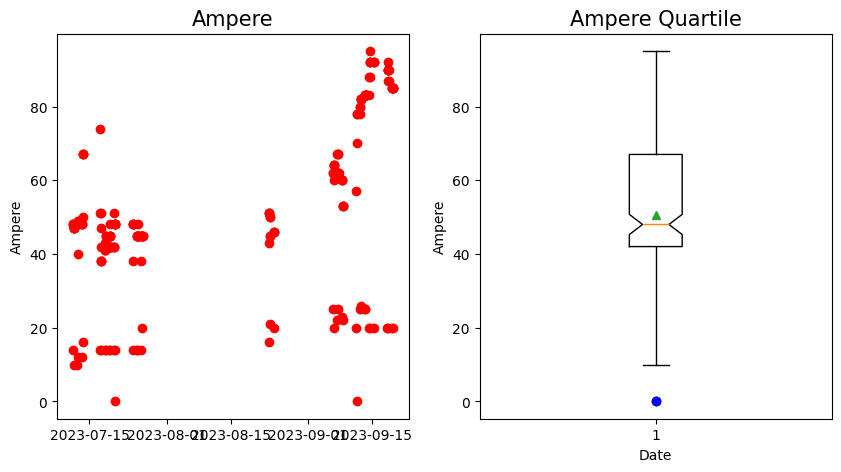

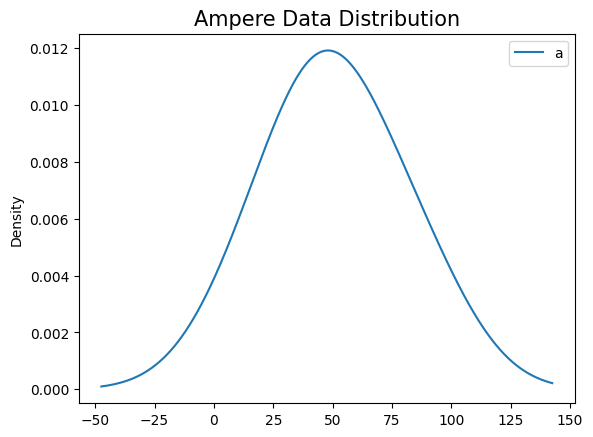

<Figure size 640x480 with 0 Axes>

In [3]:
data_a = csv_raw[['datetime', 'a']].dropna().sort_values("datetime")
data_a = data_a.set_index('datetime').sort_index()

print(f"Min : {data_a['a'].min()}")
print(f"Max : {data_a['a'].max()}")
print(f"Mean : {data_a['a'].mean()}")

# draw
plt.clf()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_a, 'ro')
plt.ylabel('Ampere')
plt.title('Ampere', fontsize=15)

plt.subplot(1,2,2)
plt.boxplot(data_a, sym="bo", notch=True, showmeans=True)
plt.xlabel('Date')
plt.ylabel('Ampere')
plt.title('Ampere Quartile', fontsize=15)

data_a.plot.kde(bw_method=1)
plt.title('Ampere Data Distribution', fontsize=15)
plt.show()

plt.tight_layout()
plt.show()

Min : 0.0
Max : 450.0
Mean : 240.6


<Figure size 640x480 with 0 Axes>

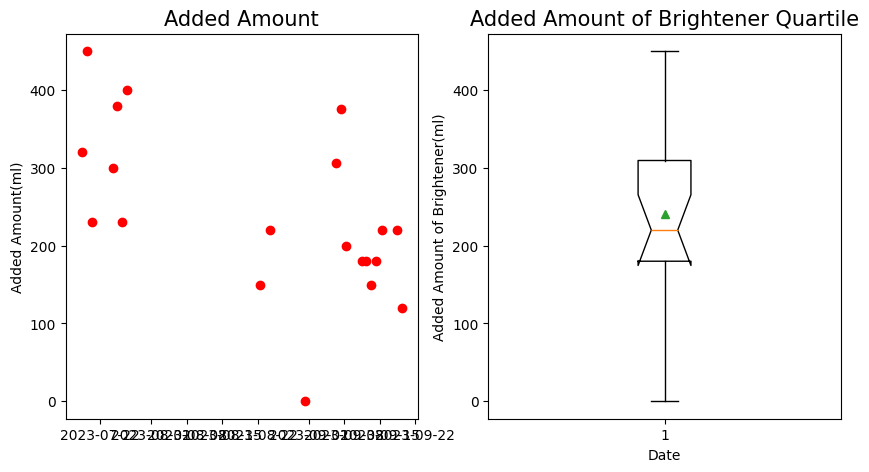

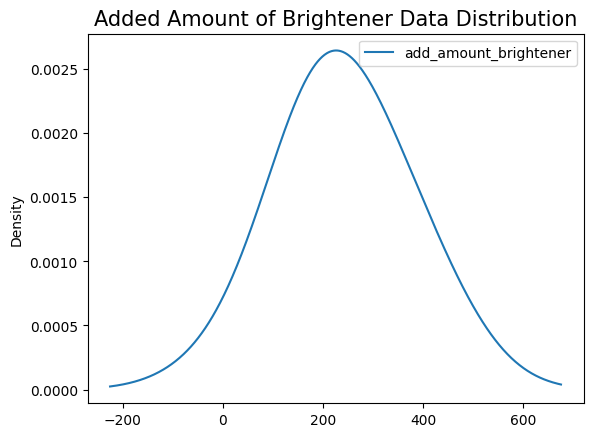

<Figure size 640x480 with 0 Axes>

In [4]:
# Brightener 유기첨가제 주입양 분포
data_brightener = csv_raw[['datetime', 'add_amount_brightener']].dropna().sort_values("datetime")
data_brightener = data_brightener.set_index('datetime').sort_index()

print(f"Min : {data_brightener['add_amount_brightener'].min()}")
print(f"Max : {data_brightener['add_amount_brightener'].max()}")
print(f"Mean : {data_brightener['add_amount_brightener'].mean()}")

# draw
plt.clf()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_brightener, 'ro')
plt.ylabel('Added Amount(ml)')
plt.title('Added Amount', fontsize=15)

plt.subplot(1,2,2)
plt.boxplot(data_brightener, sym="bo", notch=True, showmeans=True)
plt.xlabel('Date')
plt.ylabel('Added Amount of Brightener(ml)')
plt.title('Added Amount of Brightener Quartile', fontsize=15)

data_brightener.plot.kde(bw_method=1)
plt.title('Added Amount of Brightener Data Distribution', fontsize=15)
plt.show()

plt.tight_layout()
plt.show()

In [41]:
# 1. load raw data
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 2. extract usable raw component(columns)
data_dt = csv_raw[['datetime', 'warmup', 'off', 
                   'add_amount_brightener', 'add_amount_carrier', 
                   'velocity','tension','v','a','temperature',
                   'copper_sulfate_content', 'sulfuric_acid_content', 'chloride_content']].sort_values("datetime")

# 3. component data extraction
data_dt_warmup = data_dt[~data_dt["warmup"].isna()][["datetime", "warmup"]]
data_dt_off = data_dt[~data_dt["off"].isna()][["datetime", "off"]]
data_dt_brightener = (data_dt[~data_dt["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
data_dt_carrier = (data_dt[~data_dt["add_amount_carrier"].isna()])[["datetime", "add_amount_carrier"]]
data_dt_velocity = (data_dt[~data_dt["velocity"].isna()])[["datetime", "velocity"]]
data_dt_tension = (data_dt[~data_dt["tension"].isna()])[["datetime", "tension"]]
data_dt_voltage = (data_dt[~data_dt["v"].isna()])[["datetime", "v"]]
data_dt_ampere = (data_dt[~data_dt["a"].isna()])[["datetime", "a"]]
data_dt_temperature = (data_dt[~data_dt["temperature"].isna()])[["datetime", "temperature"]]
data_dt_cs = (data_dt[~data_dt["copper_sulfate_content"].isna()])[["datetime", "copper_sulfate_content"]]
data_dt_sa = (data_dt[~data_dt["sulfuric_acid_content"].isna()])[["datetime", "sulfuric_acid_content"]]
data_dt_c = (data_dt[~data_dt["chloride_content"].isna()])[["datetime", "chloride_content"]]

# create new data frame (for every single day operation)
data_dt_wt = pd.DataFrame(dtype=float, columns=['datetime', 'wt', 'add_amount_brightener', 'add_amount_carrier', 
                                                'velocity_mean', 'velocity_var', 'velocity_std',
                                                'tension_mean','tension_var', 'tension_std',
                                                'voltage_mean','voltage_var', 'voltage_std',
                                                'ampere_mean','ampere_var', 'ampere_std',
                                                'temperature_mean','temperature_var', 'temperature_std',
                                                'cs_mean','cs_var', 'cs_std',
                                                'sa_mean','sa_var', 'sa_std',
                                                'c_mean','c_var', 'c_std'])

# calculate working time diff. between warmup and off, the update
for warmup, off in zip(data_dt_warmup.iterrows(), data_dt_off.iterrows()):
    value = [off[1]["datetime"], off[1]["datetime"]-warmup[1]["datetime"]]
    value.extend([np.nan for i in range(0, data_dt_wt.shape[1]-len(value))])
    data_dt_wt.loc[len(data_dt_wt.index)] = value

data_dt_wt = data_dt_wt.groupby(pd.Grouper(key='datetime', freq='D', sort=True)).sum()
data_dt_wt = data_dt_wt[data_dt_wt["wt"]!=datetime.timedelta(seconds=0)]

# update added amount of brightener & carrier
for t_idx in data_dt_wt.index:
    mask_brightener = list((data_dt_brightener["datetime"]>t_idx) & (data_dt_brightener["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_carrier = list((data_dt_carrier["datetime"]>t_idx) & (data_dt_carrier["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_voltage = list((data_dt_voltage["datetime"]>t_idx) & (data_dt_voltage["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_ampere = list((data_dt_ampere["datetime"]>t_idx) & (data_dt_ampere["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_temperature = list((data_dt_temperature["datetime"]>t_idx) & (data_dt_temperature["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_tension = list((data_dt_tension["datetime"]>t_idx) & (data_dt_tension["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_velocity = list((data_dt_velocity["datetime"]>t_idx) & (data_dt_velocity["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_cs = list((data_dt_cs["datetime"]>t_idx) & (data_dt_cs["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_sa = list((data_dt_sa["datetime"]>t_idx) & (data_dt_sa["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_c = list((data_dt_c["datetime"]>t_idx) & (data_dt_c["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    
    if any(mask_brightener):
        data_dt_wt.loc[t_idx, "add_amount_brightener"] = data_dt_brightener.loc[mask_brightener, "add_amount_brightener"].values[0]
    if any(mask_carrier):
        data_dt_wt.loc[t_idx, "add_amount_carrier"] = data_dt_carrier.loc[mask_carrier, "add_amount_carrier"].values[0]
    if any(mask_voltage):
        data_dt_wt.loc[t_idx, "voltage_mean"] = data_dt_voltage.loc[mask_voltage, "v"].values.mean()
        data_dt_wt.loc[t_idx, "voltage_var"] = data_dt_voltage.loc[mask_voltage, "v"].values.var()
        data_dt_wt.loc[t_idx, "voltage_std"] = data_dt_voltage.loc[mask_voltage, "v"].values.std()
    if any(mask_ampere):
        data_dt_wt.loc[t_idx, "ampere_mean"] = data_dt_ampere.loc[mask_voltage, "a"].values.mean()
        data_dt_wt.loc[t_idx, "ampere_var"] = data_dt_ampere.loc[mask_voltage, "a"].values.var()
        data_dt_wt.loc[t_idx, "ampere_std"] = data_dt_ampere.loc[mask_voltage, "a"].values.std()
    if any(mask_temperature):
        data_dt_wt.loc[t_idx, "temperature_mean"] = data_dt_temperature.loc[mask_temperature, "temperature"].values.mean()
        data_dt_wt.loc[t_idx, "temperature_var"] = data_dt_temperature.loc[mask_temperature, "temperature"].values.var()
        data_dt_wt.loc[t_idx, "temperature_std"] = data_dt_temperature.loc[mask_temperature, "temperature"].values.std()
    if any(mask_cs):
        data_dt_wt.loc[t_idx, "cs_mean"] = data_dt_cs.loc[mask_cs, "copper_sulfate_content"].values.mean()
        data_dt_wt.loc[t_idx, "cs_var"] = data_dt_cs.loc[mask_cs, "copper_sulfate_content"].values.var()
        data_dt_wt.loc[t_idx, "cs_std"] = data_dt_cs.loc[mask_cs, "copper_sulfate_content"].values.std()
    if any(mask_sa):
        data_dt_wt.loc[t_idx, "sa_mean"] = data_dt_sa.loc[mask_sa, "sulfuric_acid_content"].values.mean()
        data_dt_wt.loc[t_idx, "sa_var"] = data_dt_sa.loc[mask_sa, "sulfuric_acid_content"].values.var()
        data_dt_wt.loc[t_idx, "sa_std"] = data_dt_sa.loc[mask_sa, "sulfuric_acid_content"].values.std()
    if any(mask_c):
        data_dt_wt.loc[t_idx, "c_mean"] = data_dt_c.loc[mask_cs, "chloride_content"].values.mean()
        data_dt_wt.loc[t_idx, "c_var"] = data_dt_c.loc[mask_cs, "chloride_content"].values.var()
        data_dt_wt.loc[t_idx, "c_std"] = data_dt_c.loc[mask_cs, "chloride_content"].values.std()
    if any(mask_velocity):
        data_dt_wt.loc[t_idx, "velocity_mean"] = data_dt_velocity.loc[mask_velocity, "velocity"].values.mean()
        data_dt_wt.loc[t_idx, "velocity_var"] = data_dt_velocity.loc[mask_velocity, "velocity"].values.var()
        data_dt_wt.loc[t_idx, "velocity_std"] = data_dt_velocity.loc[mask_velocity, "velocity"].values.std()
    if any(mask_tension):
        data_dt_wt.loc[t_idx, "tension_mean"] = data_dt_tension.loc[mask_tension, "tension"].values.mean()
        data_dt_wt.loc[t_idx, "tension_var"] = data_dt_tension.loc[mask_tension, "tension"].values.var()
        data_dt_wt.loc[t_idx, "tension_std"] = data_dt_tension.loc[mask_tension, "tension"].values.std()
    
        
aggregated_data = data_dt_wt.loc[data_dt_wt["add_amount_brightener"]!=0.0]
print(aggregated_data.head())

# save temporary
aggregated_data.to_csv('./aggregate.csv', sep=',')
print(aggregated_data.shape)



                                       wt  add_amount_brightener  \
datetime                                                           
2023-07-18 00:00:00+00:00 0 days 05:15:00                  320.0   
2023-07-19 00:00:00+00:00 0 days 05:45:00                  450.0   
2023-07-20 00:00:00+00:00 0 days 05:45:00                  230.0   
2023-07-24 00:00:00+00:00 0 days 03:05:00                  300.0   
2023-07-25 00:00:00+00:00 0 days 05:40:00                  380.0   

                           add_amount_carrier  velocity_mean  velocity_var  \
datetime                                                                     
2023-07-18 00:00:00+00:00               200.0          0.060  4.814825e-35   
2023-07-19 00:00:00+00:00               150.0          0.057  2.100000e-05   
2023-07-20 00:00:00+00:00               150.0          0.384  9.447840e-01   
2023-07-24 00:00:00+00:00               150.0          0.058  1.600000e-05   
2023-07-25 00:00:00+00:00               170.0          

In [11]:
# Data Augmentation & Resampling
# Multivariate Gaussian Distribution Model로 구성하여 Resampling하여 추가 데이터 확보

from sklearn.preprocessing import StandardScaler

print(aggregated_data.shape)

# 1. 각 시점마다 mean, covariance matrix 계산
mean_series = []
std_series = []
var_series = []
for idx, t_idx in enumerate(aggregated_data.index):
    # check requirements for scaling(normalization)
    
    # data extraction
    mean_series.append([data_dt_wt.loc[t_idx, "wt"], 
                        data_dt_wt.loc[t_idx, "cs_mean"],
                        data_dt_wt.loc[t_idx, "sa_mean"],
                        data_dt_wt.loc[t_idx, "velocity_mean"],
                        data_dt_wt.loc[t_idx, "tension_mean"],
                        data_dt_wt.loc[t_idx, "temperature_mean"], 
                        data_dt_wt.loc[t_idx, "ampere_mean"], 
                        data_dt_wt.loc[t_idx, "voltage_mean"], 
                        data_dt_wt.loc[t_idx, "add_amount_carrier"], 
                        data_dt_wt.loc[t_idx, "add_amount_brightener"]])
    
    std_series.append([data_dt_wt.loc[t_idx, "wt"], 
                        data_dt_wt.loc[t_idx, "cs_std"],
                        data_dt_wt.loc[t_idx, "sa_std"],
                        data_dt_wt.loc[t_idx, "velocity_std"],
                        data_dt_wt.loc[t_idx, "tension_std"],
                        data_dt_wt.loc[t_idx, "temperature_std"], 
                        data_dt_wt.loc[t_idx, "ampere_std"], 
                        data_dt_wt.loc[t_idx, "voltage_std"], 
                        data_dt_wt.loc[t_idx, "add_amount_carrier"], 
                        data_dt_wt.loc[t_idx, "add_amount_brightener"]])
    

#     cs_series = np.random.normal(data_dt_wt.loc[t_idx, 'voltage_mean'], data_dt_wt.loc[t_idx, 'voltage_std'], 50)
#     print(idx, cs_series)

# # convert numpy array
# mean_set = np.array(mean_series)
# print(mean_set.shape)
# cov_set = np.array([[]])

# #print(mean_set)
# #print(cov_set)

# #data = np.random.multivariate_normal(mean_set, cov_set, 100)

# # generate multivariate gaussian distribution
    
    
# # 평균과 공분산을 정의합니다
# mean = np.array([0, 1])
# cov = np.array([[1, 0.5], [0.5, 1]])
# print(mean.shape, cov.shape)
# data = np.random.multivariate_normal(mean, cov, 500)

# # 데이터 시각화
# # plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
# # plt.title('Multivariate Normal Distribution')
# # plt.xlabel('X1')
# # plt.ylabel('X2')
# # plt.show()

(17, 27)
0 [1.54411291 2.1466022  2.36674936 1.74323342 1.97173975 2.23175108
 2.05732353 2.08562768 1.86324266 2.09030749 1.89253357 2.10936868
 1.91674465 2.14157483 2.01485398 1.79286298 2.21657985 1.95578937
 2.07404721 1.80035961 2.12976367 2.0033815  2.13976322 2.07602762
 2.14999879 1.86064998 2.02103918 2.12554451 2.04384662 1.97052058
 1.902162   2.11440434 2.18827048 1.95797833 1.86527613 2.21898975
 2.02184689 2.0421001  2.12188506 2.0484714  1.89824976 1.81187203
 2.32218779 1.58517683 1.86321827 1.9432248  1.95734084 1.67872428
 2.19036007 2.23412212]
1 [1.7627948  1.68930565 1.84018511 2.19484114 1.87578317 2.12146598
 1.83027486 1.99688026 2.08049679 1.98612102 2.08584654 2.01836853
 2.10467964 1.98747101 1.72074064 1.93687696 2.0194381  1.70948122
 1.82915089 1.8938017  1.93967878 2.007708   2.0010634  1.94289849
 2.20695774 1.76024114 1.97804356 1.85496309 1.96998503 1.7604447
 1.8342507  1.78452005 1.96880167 2.01697029 2.03951972 1.99969427
 2.05330905 2.2815481  2.0

In [60]:
import numpy as np

# 임의의 두 시계열 데이터 생성
size = 1000
mean_1 = 0
std_1 = 1
data_1 = np.random.normal(mean_1, std_1, size)
print(data_1.shape)

mean_2 = 0
std_2 = 2
data_2 = np.random.normal(mean_2, std_2, size)

# 두 데이터를 결합하여 다변량 가우시안 분포 추정
data_combined = np.vstack((data_1, data_2)).T
mean_combined = np.mean(data_combined, axis=0)
cov_combined = np.cov(data_combined, rowvar=False)

# 다변량 가우시안 분포로부터 리샘플링
resampled_data = np.random.multivariate_normal(mean_combined, cov_combined, size)

# 결과 확인
print(resampled_data)


(1000,)
[[-1.14989755 -1.12388821]
 [-0.08915373 -0.47027815]
 [-2.29135706  1.64929806]
 ...
 [ 1.25764367  0.47005978]
 [ 0.72762247 -0.6310014 ]
 [ 1.4216522   0.55462178]]


score :  0.9999938766798432
(200, 1)
X_new: (200,)
Y_pred: (200,)
Y_std: (200, 3)
Score :  1.0


/Users/byunghunhwang/dev/flame-ffc-model/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


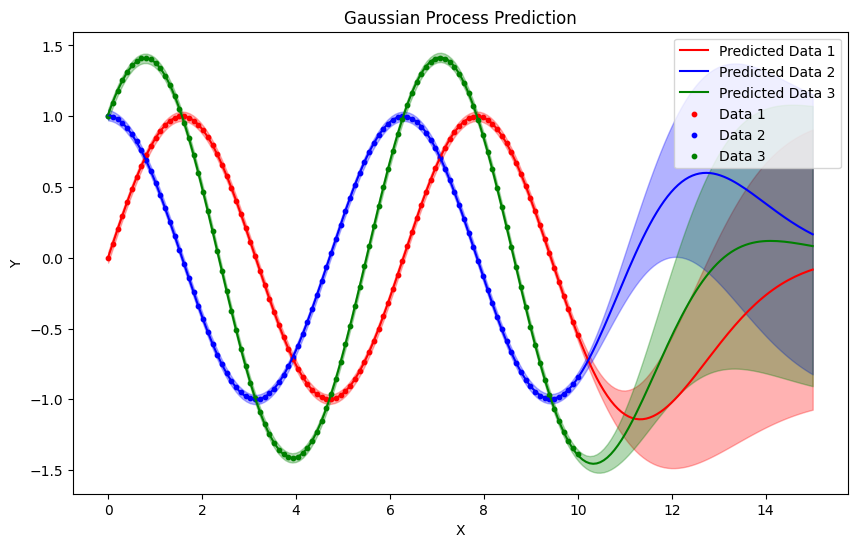

In [40]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
import matplotlib.pyplot as plt

# 3가지 시계열 데이터 생성
size = 100
t = np.linspace(0, 10, size)
data1 = np.sin(t)
data2 = np.cos(t)
data3 = np.sin(t) + np.cos(t)

# 가우시안 프로세스 모델 정의
X = t.reshape(-1, 1)
y = np.column_stack((data1, data2, data3))
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1e3))
# kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(X,y) # train model

print("score : ", gp.score(X,y))

# 새로운 데이터에 대한 예측
new_t = np.linspace(0, 15, 200)
X_new = new_t.reshape(-1, 1)
print(X_new.shape)
y_pred, y_std = gp.predict(X_new, return_std=True)

# 결과 출력
print("X_new:", X_new.ravel().shape)
print("Y_pred:", y_pred[:,0].ravel().shape)
print("Y_std:", y_std.shape)
print("Score : ", gp.score(X_new, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(X_new.ravel(), y_pred[:, 0], 'r', label='Predicted Data 1')
plt.fill_between(X_new.ravel(), y_pred[:, 0] - y_std[:,0], y_pred[:, 0] + y_std[:,0], alpha=0.3, color='r')

plt.plot(X_new, y_pred[:, 1], 'b', label='Predicted Data 2')
plt.fill_between(X_new.ravel(), y_pred[:, 1] - y_std[:,1], y_pred[:, 1] + y_std[:,1], alpha=0.3, color='b')

plt.plot(X_new, y_pred[:, 2], 'g', label='Predicted Data 3')
plt.fill_between(X_new.ravel(), y_pred[:, 2] - y_std[:,2], y_pred[:, 2] + y_std[:,2], alpha=0.3, color='g')

plt.scatter(X, y[:, 0], c='r', label='Data 1', s=10)
plt.scatter(X, y[:, 1], c='b', label='Data 2', s=10)
plt.scatter(X, y[:, 2], c='g', label='Data 3', s=10)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Process Prediction')
plt.legend()
plt.show()


In [285]:
# K Nearest Neighbor Regression
# 샘플수가 너무 작아서 knn과 같은 비모수적 방법에서 이웃데이터의 수에 너무 크게 작용
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = aggregated_data.loc[:,["cs_mean", "sa_mean", "velocity_mean", "tension_mean", "voltage_mean", "ampere_mean"]].values
y = aggregated_data.loc[:, ["add_amount_brightener"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)
predictions = knn_regressor.predict(X_test)

print('R-squared Score:', r2_score(y_pred=predictions, y_true=y_test))

R-squared Score: -0.31705806451612917


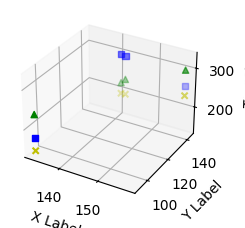

R-squared Score: -0.30681264548333154


In [292]:
# Support Vector Regression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = aggregated_data.loc[:,["cs_mean", "sa_mean", "velocity_mean", "tension_mean", "voltage_mean", "ampere_mean"]].values
y = aggregated_data.loc[:, ["add_amount_brightener"]].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin = svr_lin.fit(X_train, y_train).predict(X_test)
y_poly = svr_poly.fit(X_train, y_train).predict(X_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_rbf, c='g', marker='^')
ax.scatter(X_test[:, 0], X_test[:, 1], y_lin, c='b', marker='s')
ax.scatter(X_test[:, 0], X_test[:, 1], y_poly, c='y', marker='x')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Target')
plt.show()

print('R-squared Score:', r2_score(y_pred=y_rbf, y_true=y_test))


In [ ]:
# GP Model

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import matplotlib.pyplot as plt

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)


plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')